In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# Dosya yolu
file_path = r"C:\Users\AKBASLI\OneDrive - Cleveland Clinic\Desktop\NEORAS\NEORAS_NICU_FinalDataset_20240619.txt"

# Veriyi pandas ile okuma
data = pd.read_csv(file_path, delimiter="\t", header=0)

In [2]:
data.ChildReadmissionFirstMonth.value_counts()

ChildReadmissionFirstMonth
N    4101
Y      32
Name: count, dtype: int64

In [3]:
abortions = data[data['Spontaneous abortion'] == 'Y'].shape[0]
print(f"Number of abortions: {abortions}")
data = data[data['Spontaneous abortion'] != 'Y'] # Eliminates to abortions
# Create the target feature
data['target'] = (                                                          # Inclusion criteria
                (data.ChildOfficeVisitsFirstMonth > 5) |                  # 3 or more office visits
                  (data.ChildER_VisitFirstMonth == 'Y') |                   # ER visit
                  (data.ChildReadmissionFirstMonth == 'Y')).astype(int)     # Readmission

data = data[data.ChildLengthOfStayHours <= (24*7*2)]
# Drop the specified features because they are already merged into the target feature
features_to_drop = ['ChildOfficeVisitsFirstMonth', 'ChildER_VisitFirstMonth', 'ChildReadmissionFirstMonth']
data.drop(columns=features_to_drop, inplace=True)

# Display the first few rows of the updated dataframe
data.target.value_counts()

Number of abortions: 33


target
0    2603
1     264
Name: count, dtype: int64

In [4]:
# Race feature engineering
data['MaternalRace'] = data['MaternalRace'].apply(lambda x: x if x in ['Caucasian', 'Black race'] else 'Other')
data['MaternalRace'].value_counts()

MaternalRace
Caucasian     1968
Black race     493
Other          406
Name: count, dtype: int64

In [5]:
# Marital status feature engineering
data.LatestMaritalStatus.fillna('Currently Married', inplace=True)
data['LatestMaritalStatus'] = data['LatestMaritalStatus'].apply(lambda x: 'Motherwithsomebody' if x in ['Currently Married', 'domestic partner', 'Other - Marital Status'] else 'Onlymother')
data['LatestMaritalStatus'].value_counts()

LatestMaritalStatus
Motherwithsomebody    1846
Onlymother            1021
Name: count, dtype: int64

In [6]:
# Parity feature engineering
data['Parity'].fillna(0, inplace=True)
data['Parity_Status'] = data['Parity'].apply(
    lambda x: 'nullipar' if x == 0 else
              'primipar' if x == 1 else
              #'grandmultipar' if x >= 5 else
              'multipar'
)
data['Parity_Status'].value_counts()


Parity_Status
nullipar    1567
primipar     789
multipar     511
Name: count, dtype: int64

In [7]:
# Gravida feature engineering
data['Gravida'].replace(0, 1, inplace=True)
data['Gravida_Status'] = data['Gravida'].apply(lambda x: 'primigravid' if x == 1 else 'multigravid')
data['Gravida_Status'].value_counts()

Gravida_Status
multigravid    1738
primigravid    1129
Name: count, dtype: int64

In [8]:
# Gestational age feature engineering
data['GestWeek'] = data['GestAge_Days'] / 7
data.drop(columns=['GestAge_Days'], inplace=True)
# def categorize_gestational_age(weeks):
#     if weeks < 28:
#         return 'ExtremelyPreterm'
#     elif 28 <= weeks < 32:
#         return 'VeryPreterm'
#     elif 32 <= weeks < 37:
#         return 'ModeratelyPreterm'
#     elif 37 <= weeks < 39:
#         return 'EarlyTerm'
#     elif 39 <= weeks < 41:
#         return 'FullTerm'
#     # elif 41 <= weeks < 42:
#     #     return 'Late Term'
#     else:
#         return 'Postterm'
def categorize_gestational_age(weeks):
    if weeks < 35:
        return 'Preterm'
    elif 35 <= weeks < 37:
        return 'ModeratelyPreterm'
    else:
        return 'Term'
# Apply the function to create a new column
data['Gestational_Category'] = data['GestWeek'].apply(categorize_gestational_age)
data['Gestational_Category'].value_counts()


Gestational_Category
Term                 1834
Preterm               524
ModeratelyPreterm     509
Name: count, dtype: int64

In [9]:
# Delivery method feature engineering
data['DeliveryDate'] = pd.to_datetime(data['DeliveryDate'])
data['deliverymonth'] = data['DeliveryDate'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['deliveryseason'] = data['deliverymonth'].apply(get_season)
data['dischargeseason'] = data['DischargeMonth'].apply(get_season)
data.drop(columns=['DeliveryDate', 'deliverymonth', 'DischargeMonth'], inplace=True)
display(data.deliveryseason.value_counts())
display(data.dischargeseason.value_counts())



deliveryseason
Winter    740
Summer    732
Spring    703
Fall      692
Name: count, dtype: int64

dischargeseason
Winter    733
Summer    716
Fall      711
Spring    707
Name: count, dtype: int64

In [10]:
# Delivery type feature engineering
data['DeliveryType'] = data['DeliveryType'].apply(lambda x: 'Vaginal' if x in ['Vaginal', 'VBAC', 'Vacuum-assisted', 'Vacuum', np.nan] else 'CS')
data['DeliveryType'].value_counts()

DeliveryType
CS         1454
Vaginal    1413
Name: count, dtype: int64

In [11]:
# Birth weight feature engineering
# data['BirthWeight_Category'] = data['BirthWeight_Grams'].apply(
#     lambda x: 'ELBW' if x < 1000 else # Extremely Low Birth Weight
#               'VLBW' if x < 1500 else # Very Low Birth Weight
#               'LBW' if x < 2500 else  # Low Birth Weight
#               'NBW' if x < 4000 else  # Normal Birth Weight
#               'HBW'                   # High Birth Weight
# )
data['BirthWeight_Category'] = data['BirthWeight_Grams'].apply(
    lambda x: 'LBW' if x < 2500 else # Extremely Low Birth Weight
              'NBW' if x < 4000 else  # Normal Birth Weight
              'HBW'                   # High Birth Weight
)
data['BirthWeight_Category'].value_counts()



BirthWeight_Category
NBW    1914
LBW     747
HBW     206
Name: count, dtype: int64

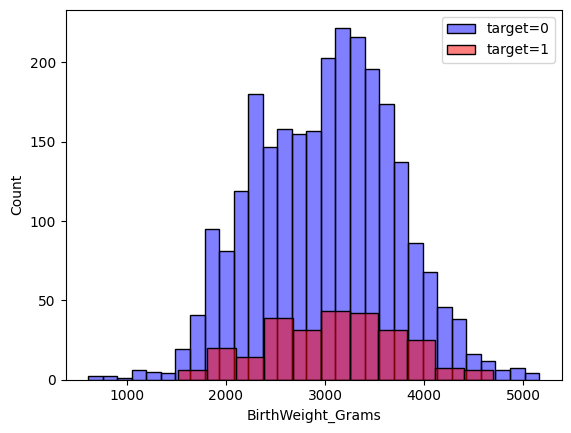

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
i = 'BirthWeight_Grams'
sns.histplot(data[(data.target==0)][i], color='blue', alpha=0.5, label='target=0')
#sns.histplot(data[(data.target==0)&(data[i]<672)][i], color='blue', alpha=0.5, label='target=0')
sns.histplot(data[data.target==1][i], color='red', alpha=0.5, label='target=1')
plt.legend()

In [13]:
# Any infection feature engineering
data['AnynonGBSInfection'] = data[[
                                    'HepB_PositiveDuringPregnancy', 'HCV_PositiveDuringPregnancy', 
                                    'HIV_PositiveDuringPregnancy', 'SyphilisPositiveDuringPregnancy', 
                                 ]].apply(lambda row: 'Y' if 'Y' in row.values else 'N', axis=1)

data.drop(columns=['HepB_PositiveDuringPregnancy', 'HCV_PositiveDuringPregnancy', 'HIV_PositiveDuringPregnancy', 'SyphilisPositiveDuringPregnancy'], inplace=True)
data['AnynonGBSInfection'].value_counts()



AnynonGBSInfection
N    2812
Y      55
Name: count, dtype: int64

In [14]:
# Any drug abuse feature engineering
data['AnyDrugAbusiveBehavior'] = data[[                   
                                    'Suboxone_DuringPregnancy',
                                    'Methadone_DuringPregnancy',
                                    'PositiveDrugScreenDuringPregnancy',
]].apply(lambda row: 'Y' if 'Y' in row.values else 'N', axis=1)
data.drop(columns=[ 'Suboxone_DuringPregnancy', 'Methadone_DuringPregnancy', 'PositiveDrugScreenDuringPregnancy'], inplace=True)
data.rename(columns={'Alcohol abuse':'Alcohol',
                     'Smoking during pregnancy':'Smoking',
                     'SSRI_DuringPregnancy':'SSRI'}, inplace=True)
data['AnyDrugAbusiveBehavior'].value_counts()     


AnyDrugAbusiveBehavior
N    2706
Y     161
Name: count, dtype: int64

In [15]:
# Any prenatal complications feature engineering
data['AnyPreNatalComp'] = data[[
                           'Antepartum Haemorrhage','Eclampsia','IUGR',
                           'Maternal chronic hypertension','Maternal Diabetes',
                           'Maternal pregnancy-induced hypertension','Oligohydramnios',
                           'Placenta previa','Polyhydramnios','Pre-eclampsia',
                           'Preterm premature rupture of membranes',
                         ]].apply(lambda row: 'Y' if any(row == 'Y') else 'N', axis=1)

data.AnyPreNatalComp.value_counts()      




AnyPreNatalComp
Y    2042
N     825
Name: count, dtype: int64

In [16]:
# Fill missing Cord_pH_Venous with Cord_pH_Arterial values
data['Cord_pH_Venous'].fillna(data['Cord_pH_Arterial'], inplace=True)

# Fill missing Cord_pH_Arterial with Cord_pH_Venous values
data['Cord_pH_Arterial'].fillna(data['Cord_pH_Venous'], inplace=True)
data.Cord_pH_Venous.isnull().sum(), data.Cord_pH_Arterial.isnull().sum()

(607, 607)

In [17]:
# Convert temperatures greater than 42 from Fahrenheit to Celsius
data['MaxTemperature'] = data['MaxTemperature'].apply(lambda x: (x - 32) * 5.0/9.0 if x > 42 else x)
data['MinTemperature'] = data['MinTemperature'].apply(lambda x: (x - 32) * 5.0/9.0 if x > 42 else x)
data['MaxTemperature'].isnull().sum(), data['MinTemperature'].isnull().sum()

(54, 54)

In [18]:
# Glucose feature engineering
data['DifferGlc'] = data['MaxBloodGlucose'] - data['MinBloodGlucose']
data.loc[data[data.DifferGlc == 0].index, 'MinBloodGlucose'] = np.nan
data.loc[data[data.MinBloodGlucose > 90].index, 'MinBloodGlucose'] = np.nan
data.drop(columns=['DifferGlc'], inplace=True)
data['MinBloodGlucose'].isnull().sum(), data['MaxBloodGlucose'].isnull().sum()

(264, 102)

In [19]:
data['Cord_pH_Venous'].fillna(data['Cord_pH_Arterial'], inplace=True)

data.loc[data[data.MaxTranscutaneousBilirubin > 14].index, 'MaxTranscutaneousBilirubin'] = np.nan

data['MinSerumBilirubin'].fillna(data['MinTranscutaneousBilirubin'], inplace=True)
data['MaxSerumBilirubin'].fillna(data['MaxTranscutaneousBilirubin'], inplace=True)
data.drop(columns=['MinTranscutaneousBilirubin', 'MaxTranscutaneousBilirubin'], inplace=True)


In [20]:
# New columns: Parity_Status, Gravida_Status, GestWeek, Gestational_Category, deliveryseason, dischargeseason, BirthWeight_Category, AnynonGBSInfection, AnyDrugAbusiveBehavior
# Alcohol, Smoking, SSRI, AnyPreNatalComp

In [21]:
i = 'FeedingType'
data[i].value_counts()
data[i].isnull().sum()

1299

In [22]:
## ROM_Time is in seconds.  44507 seconds = 12.36 hours
# Vaginal delivery is based on diagnoses and isn’t very consistent.  I’d use DeliveryType
# No imputation was done on my end, it’s the data that are in Epic
# No imputation was done on my end, it’s the data that are in Epic
# It’s the number of times the baby failed the car seat test.  0 failures = tested and passed the 1st time
# This was not calculated and was extracted from the last value recorded for the baby during the post-delivery admission

In [23]:
# Replace the incorrect values for PercentWeightLoss
# Some patients really had high weight loss, but the values are incorrect or weight gain
data.PercentWeightLoss.replace(-27.4, -2.7, inplace=True)
data.PercentWeightLoss.replace(-93.4, -9.3, inplace=True)
data.PercentWeightLoss.replace(102287.5, -3, inplace=True)
data[data.PercentWeightLoss<-15].PercentWeightLoss.values

array([-16.3, -16.4])

In [24]:
data['ROM_hr'] = data.ROM_Time/1440 # https://onlinelibrary.wiley.com/doi/full/10.1155/2018/4823404
data['PROM'] = data.ROM_hr.apply(lambda x: 'Y' if x >= 16 else 'N')
# Create Early-Onset Sepsis (EOS) risk indicator - when both prolonged rupture of membranes and infection are present
data['EOS'] = data.apply(lambda row: 'Y' if row['PROM'] == 'Y' and row['AnynonGBSInfection'] == 'Y' else 'N', axis=1) # https://neonatalsepsiscalculator.kaiserpermanente.org/Classification.aspx
data.drop(columns=['ROM_Time'], inplace=True)

In [25]:
data['LongABUsage'] = data.ChildNumberOfAntibioticDays.apply(lambda x: 'Y' if x > 2 else 'N')
data.drop(columns=['ChildNumberOfAntibioticDays'], inplace=True)
data['LongABUsage'].value_counts()

LongABUsage
N    2237
Y     630
Name: count, dtype: int64

In [26]:
data.ChildBloodCultureCount.value_counts()

ChildBloodCultureCount
1    2121
0     654
2      83
3       7
4       2
Name: count, dtype: int64

In [27]:
'FailedHearing',
'CarSeatTestFailures', # Categorical
'FeedingType',
'PercentWeightLoss',
'ChildNumberOfAntibioticDays',
'ChildBloodCultureCount',



('ChildBloodCultureCount',)

In [28]:

# i = 'ChildNumberOfAntibioticDays' # 'HIE_Severity', 'HighestIVH_Grade',

# print('General')
# print('Data missing rate:', data[i].isnull().mean().round(3) * 100)
# display(data[i].value_counts(normalize=True) * 100)
# print('Target 1')
# display(data[data.target==1][i].value_counts(normalize=True) * 100)
# print('Target 0')
# display(data[data.target==0][i].value_counts(normalize=True) * 100)

# #data[i].unique()

In [29]:
# Fill missing Cord_pH_Venous with Cord_pH_Arterial values
data['Cord_pH_Venous'].fillna(data['Cord_pH_Arterial'], inplace=True)

# Fill missing Cord_pH_Arterial with Cord_pH_Venous values
data['Cord_pH_Arterial'].fillna(data['Cord_pH_Venous'], inplace=True)

In [30]:
data['MaxHeartRate'].isna().sum() / len(data)

0.01848622253226369

In [31]:
# for cols in data.columns:
#     print(f"'{cols}',")
'MaternalPatientID',
'MaternalMedicalRecordNumber',
'ChildPatientID',
'ChildMedicalRecordNumber',
'ChildEncounterID',
'MaternalLanguage',
'MyChartAccess',
'YearsOfEducation'
'GestationalAge_Weeks',
'ChildDeathDate'
'MaternalDeathDate'
'ChildRace', 'ChildEthnicity',
'ROM_Time', # This feature's mean of values is 44507. If it is in seconds it is too much. It is like 30 days. Can you describe this feauture's time unit?
'ER_VisitDuringPregnancy',
'Vaginal delivery',
'Pregnancy Complications',
'HIE_Severity', 'HighestIVH_Grade', # Missed values drop it
'Cord_pH_Venous_Date', 'Cord_pH_Arterial_Date',
# Drop columns are upside

'MaternalAgeAtDelivery',
'MaternalRace',
'LatestMaritalStatus',

'Gravida', 'Gravida_Status',
'Parity', 'Parity_Status',

'GestWeek', 'Gestational_Category',

#'DeliveryDate',
'deliverymonth', 'deliveryseason',
'ChildGender',


'ChildLengthOfStayHours',
'DischargeMonth', 'dischargeseason',
'DeliveryType',

#'Spontaneous abortion',
'Umbilical cord prolapse',

'AppointmentMadeDuringAdmission',
'AnyPreNatalComp'

'MultipleGestation', # Ask Ani
'BirthWeight_Grams', 'BirthWeight_Category', # Ask Ani
'SGA',

'Mother_BMI_AtDelivery', 'PrePregnancyWeight_KG',

# 'SSRI_DuringPregnancy',
# 'Suboxone_DuringPregnancy',
# 'Methadone_DuringPregnancy',
# 'PositiveDrugScreenDuringPregnancy',
# 'Alcohol abuse',
# 'Smoking during pregnancy',
'Alcohol', 'Smoking', 'SSRI', 'AnyDrugAbusiveBehavior'

# 'HepB_PositiveDuringPregnancy',
# 'HCV_PositiveDuringPregnancy',
# 'HIV_PositiveDuringPregnancy',
# 'SyphilisPositiveDuringPregnancy',
'AnynonGBSInfection'
'GBS_PositiveDuringPregnancy',

# Prenatal complications
'Antepartum Haemorrhage',
'Eclampsia',
'IUGR', # Ask Ani
'Maternal chronic hypertension',
'Maternal Diabetes',
'Maternal pregnancy-induced hypertension',
'Oligohydramnios',
'Placenta previa',
'Polyhydramnios',
'Pre-eclampsia',
'Preterm premature rupture of membranes', # This rate is meaningful. 


'Apgar1Minute','Apgar5Minute',
'Cord_pH_Venous', 'Cord_pH_Arterial',
'MaxHeartRate', 'MinHeartRate', 'AvgHeartRate', # Fill with median but first clean the data
'AvgPulseOx', # Fill with median but first clean the data
'Desaturations', # Fill with median but first clean the data # Most valuable feature for PPG
'Desaturations_5DaysBeforeDischarge', 'Bradycardia_5DaysBeforeDischarge', # Should be dropped
'SurfactantDoses',  # Inconsistent data
'MaxTemperature', 'MinTemperature', # If value bigger than 42 change to F to C // 37.50 israndomly filling????
'MaxFiO2', # Should be dropped
'MinBloodGlucose', 'MaxBloodGlucose', # 143 pt Max Glucose level same with Min Glucose level I think is we should use Min Glucose level
'GlucoseGelGiven', # More valueable than Glucose levels
'MinSerumBilirubin', 'MaxSerumBilirubin', 'MaxTranscutaneousBilirubin', 'MinTranscutaneousBilirubin',
'Phototherapy', # More valueable than Bilirubin levels
'MinSodium', 'MaxSodium',
'MinHemoglobin',
'NoUrineOutputShift', # should be dropped

'FailedHearing',
'CarSeatTestFailures', # Ask Alex This feature has 4 uniqe values 0,1,2,3. What is the meaning of this values?
'FeedingType',
'PercentWeightLoss', # Ask Alex How calculated this feature some of the values are around the 90 it is impossible
'ChildNumberOfAntibioticDays',
'ChildBloodCultureCount', ## doesnt necessary
'target',


('target',)

In [32]:
data.rename(columns={'Antepartum Haemorrhage':'Antepartum_Haemorrhage',
                     'Maternal chronic hypertension':'Maternal_chronic_hypertension',
                        'Maternal Diabetes':'Maternal_Diabetes',
                        'Maternal pregnancy-induced hypertension':'Maternal_pregnancy_induced_hypertension',
                        'Preterm premature rupture of membranes':'Preterm_premature_rupture_of_membranes',
                        'Placenta previa':'Placenta_previa',
                        'Pregnancy Complications':'Pregnancy_Complications',
                        'Pre-eclampsia':'Pre_eclampsia',
                        'Umbilical cord prolapse':'Umbilical_cord_prolapse',
                        

                     }, inplace=True)

In [33]:
# for i in data.columns:
#     print(f"'{i}',")
# Identity features
'MaternalPatientID',
'MaternalMedicalRecordNumber',
'ChildPatientID',
'ChildMedicalRecordNumber',
'ChildEncounterID',

# Maternal features
'MaternalAgeAtDelivery', # doesnt significant
'MaternalRace', #Black race OR 0.34 important categorical feature
'MaternalLanguage', # doesnt significant
'MyChartAccess', # doesnt significant
'LatestMaritalStatus', # Only mother OR 0.83
'YearsOfEducation', # doesnt significant

# Prenatal features
'Gravida', # OR 0.91
'Parity', # OR 0.81
'MultipleGestation', # Yes OR 0.56
'ER_VisitDuringPregnancy', # doesnt significant
'Mother_BMI_AtDelivery', # doesnt significant
'PrePregnancyWeight_KG', # doesnt significant

'SSRI', #doesn't significant
'GBS_PositiveDuringPregnancy', # doesn't significant
'Alcohol', #doesn't significant
'Antepartum_Haemorrhage',#doesn't significant
'Eclampsia',#doesn't significant
'IUGR',#doesn't significant
'Maternal_chronic_hypertension', # Y OR 0.68
'Maternal_Diabetes', # Y OR 1.27
'Maternal_pregnancy_induced_hypertension',
'Oligohydramnios', # Y OR 0.61 p 0.06
'Placenta_previa',#doesn't significant
'Polyhydramnios',#doesn't significant
'Pre_eclampsia',#doesn't significant
'Pregnancy_Complications',#doesn't significant
'Preterm_premature_rupture_of_membranes',#doesn't significant
'Smoking',#doesn't significant
'Umbilical_cord_prolapse',#doesn't significant

'Parity_Status', #nullipar OR 1.71
'Gravida_Status', #primigravid OR 1.45
'GestWeek', # OR 1.22
'Gestational_Category', # Intrestingly preterms are not more risky than term babies OR 0.52
'deliveryseason',
'dischargeseason', # Winter is important OR 0.78

# Natal features
'GestationalAge_Weeks',
'ChildGender',
'DeliveryType', # Vaginal OR 1.29
'BirthWeight_Grams', # OR 1.16
'SGA',
'Vaginal delivery',
'Apgar1Minute', #OR 0.85
'Apgar5Minute', #OR 0.84
'HIE_Severity',
'Cord_pH_Venous_Date',
'Cord_pH_Venous',
'Cord_pH_Arterial_Date',
'Cord_pH_Arterial', # OR 0.9

'BirthWeight_Category', # Interestingly LBW is not more risky than NBW OR 0.73 p 0.08
'AnynonGBSInfection',
'AnyDrugAbusiveBehavior', # OR 0.59
'AnyPreNatalComp',
'ROM_hr',
'PROM', # OR 1.4
'EOS',
'LongABUsage',

# Postnatal features
'ChildLengthOfStayHours', # OR 0.67
'MaxHeartRate',
'MinHeartRate', # OR 1.1
'AvgHeartRate',
'AvgPulseOx',
'Desaturations', # Y OR 0.8
'Desaturations_5DaysBeforeDischarge',
'Bradycardia_5DaysBeforeDischarge',
'SurfactantDoses',
'MaxTemperature',
'MinTemperature',
'MaxFiO2',
'MinBloodGlucose',
'MaxBloodGlucose',
'GlucoseGelGiven', # Y OR 1.44
'MinSerumBilirubin',
'MaxSerumBilirubin',
'Phototherapy',
'MinSodium',
'MaxSodium',
'MinHemoglobin', # OR 0.86
'NoUrineOutputShift',
'FailedHearing', # Y OR 1.43
'CarSeatTestFailures',
'FeedingType', # Missing data quite large but we can share this: Formula OR 0.34 Human milk OR 1.32 Combined OR 1.26
'PercentWeightLoss', # OR 0.83
'ChildBloodCultureCount',
'HighestIVH_Grade',

'target',





('target',)

In [34]:
# Material features
# Pre-natal features

In [35]:
def calculate_odds_ratio(data, variable):
    """
    Calculate odds ratio for a categorical variable in relation to the target variable.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing the variables
    variable : str
        The name of the categorical variable to analyze
    
    Returns:
    --------
    pandas.DataFrame
        A DataFrame with odds ratios, confidence intervals, and p-values
    """
    import statsmodels.formula.api as smf
    
    # Create a copy to avoid modifying original data
    df = data[[variable, 'target']].copy().dropna(subset=[variable])
    
    # Make sure variable is treated as category type
    df[variable] = df[variable].astype('category')
    
    # Get reference category (first category alphabetically)
    reference_category = sorted(df[variable].unique())[0]
    
    # Fit logistic regression using formula API
    formula = f"target ~ C({variable}, Treatment(reference='{reference_category}'))"
    model = smf.logit(formula, data=df)
    result = model.fit(disp=0)
    
    # Get odds ratios and confidence intervals
    odds_ratios = pd.DataFrame({
        'Odds Ratio': np.exp(result.params),
        '95% CI Lower': np.exp(result.conf_int()[0]),
        '95% CI Upper': np.exp(result.conf_int()[1]),
        'p-value': result.pvalues
    })
    
    # Add formatted odds ratio with CI
    odds_ratios['OR with CI'] = odds_ratios.apply(
        lambda row: f"{row['Odds Ratio']:.2f} ({row['95% CI Lower']:.2f}-{row['95% CI Upper']:.2f})", 
        axis=1
    )
    
    # Format the dataframe
    odds_ratios = odds_ratios.reset_index()
    odds_ratios = odds_ratios.rename(columns={'index': 'Category'})
    
    # Clean up category names
    odds_ratios['Category'] = odds_ratios['Category'].str.replace(f"C({variable}, Treatment(reference='{reference_category}'))[", "", regex=False)
    odds_ratios['Category'] = odds_ratios['Category'].str.replace("]", "", regex=False)
    odds_ratios.loc[odds_ratios['Category'] == 'Intercept', 'Category'] = 'Intercept'
    
    # Add reference column
    odds_ratios['Reference'] = reference_category
    
    # Reorder columns
    final_cols = ['Category', 'Reference', 'OR with CI', 'Odds Ratio', '95% CI Lower', '95% CI Upper', 'p-value']
    odds_ratios = odds_ratios[final_cols]
    
    return odds_ratios



In [36]:
def evaluate_numeric_feature(data, variable):
    """
    Evaluate a numeric feature in relation to a binary target using logistic regression,
    but first standardize (z-score) the numeric variable so that the coefficient reflects
    a one-standard-deviation change instead of a one-unit change.
    Returns a DataFrame with odds ratio, confidence interval, and p-value.
    """
    import numpy as np
    import pandas as pd
    import statsmodels.formula.api as smf
    from sklearn.preprocessing import StandardScaler

    # Drop rows with missing values for this variable and the target
    df = data[[variable, 'target']].copy().dropna()

    # Standardize the numeric variable
    scaler = StandardScaler()
    df['var_scaled'] = scaler.fit_transform(df[[variable]])

    # Fit logistic regression on the scaled variable
    formula = "target ~ var_scaled"
    model = smf.logit(formula, data=df)
    result = model.fit(disp=0)

    # Extract odds ratio and confidence interval
    import math
    coef = result.params
    conf_int = result.conf_int()
    odds_ratios = pd.DataFrame({
        'Coefficient': coef,
        'Odds Ratio': np.exp(coef),
        '95% CI Lower': np.exp(conf_int[0]),
        '95% CI Upper': np.exp(conf_int[1]),
        'p-value': result.pvalues
    })

    # Create a readable odds ratio with confidence interval string
    odds_ratios['OR (95% CI)'] = odds_ratios.apply(
        lambda row: f"{row['Odds Ratio']:.2f} "
                    f"({row['95% CI Lower']:.2f}-{row['95% CI Upper']:.2f})",
        axis=1
    )
    odds_ratios = odds_ratios[['Coefficient',  'p-value', 'OR (95% CI)']]

    return odds_ratios.round(4)


evaluate_numeric_feature(data, 'MaternalAgeAtDelivery')

,Coefficient,p-value,OR (95% CI)
Intercept,-2.2973,0.0000,0.10 (0.09-0.11)
var_scaled,-0.1470,0.0227,0.86 (0.76-0.98)


In [37]:
# Calculate odds ratios for MaternalRace
# MaternalLanguage, MaternalRace, MyChartAccess, LatestMaritalStatus, MultipleGestation, ER_VisitDuringPregnancy, SSRI
odds_ratios_race = calculate_odds_ratio(data, 'FeedingType')
# Display the results
odds_ratios_race[['Category', 'Reference', 'OR with CI', 'p-value']].round(4)




,Category,Reference,OR with CI,p-value
0,Intercept,Formula,0.08 (0.05-0.14),0.0000
1,T.Human Milk,Formula,1.19 (0.70-2.05),0.5188
2,T.Human Milk+Formula,Formula,1.25 (0.68-2.31),0.4750


In [38]:
# MaternalAgeAtDelivery, YearsOfEducation, Gravida
evaluate_numeric_feature(data, 'PercentWeightLoss')

,Coefficient,p-value,OR (95% CI)
Intercept,-2.2769,0.0000,0.10 (0.09-0.12)
var_scaled,0.0126,0.8444,1.01 (0.89-1.15)


In [39]:
# for i in data.columns:
#     print(f"'{i}',")
# Identity features
data = data[[


# Maternal features

'MaternalRace', #Black race OR 0.34 important categorical feature
'LatestMaritalStatus', # Only mother OR 0.83


# Prenatal features

'MultipleGestation', # Yes OR 0.56

'Maternal_chronic_hypertension', # Y OR 0.68
'Maternal_Diabetes', # Y OR 1.27
'Oligohydramnios', # Y OR 0.61 p 0.06

'Parity_Status', #nullipar OR 1.71
'Gravida_Status', #primigravid OR 1.45
'GestWeek', # OR 1.22
'Gestational_Category', # Intrestingly preterms are not more risky than term babies OR 0.52
'dischargeseason', # Winter is important OR 0.78

# Natal features
'DeliveryType', # Vaginal OR 1.29
'BirthWeight_Grams', # OR 1.16
'Apgar1Minute', #OR 0.85
'Apgar5Minute', #OR 0.84
'Cord_pH_Arterial', # OR 0.9

'BirthWeight_Category', # Interestingly LBW is not more risky than NBW OR 0.73 p 0.08
'AnyDrugAbusiveBehavior', # OR 0.59
'PROM', # OR 1.4

# Postnatal features
'ChildLengthOfStayHours', # OR 0.67
'MinHeartRate', # OR 1.1
'Desaturations', # Y OR 0.8
'GlucoseGelGiven', # Y OR 1.44
'MinHemoglobin', # OR 0.86
'FailedHearing', # Y OR 1.43
'PercentWeightLoss', # OR 0.83


'target',]]





In [40]:
categoric_columns = [
'MaternalRace',
'LatestMaritalStatus',
'MultipleGestation',
'Maternal_chronic_hypertension',
'Maternal_Diabetes',
'Oligohydramnios',
'Parity_Status',
'Gravida_Status',
'Gestational_Category',
'dischargeseason',
'DeliveryType',
'BirthWeight_Category',
'AnyDrugAbusiveBehavior',
'PROM',
'Desaturations',
'GlucoseGelGiven',
'FailedHearing'
]
numeric_columns = [
'GestWeek',
'BirthWeight_Grams',
'Apgar1Minute',
'Apgar5Minute',
'Cord_pH_Arterial',
'ChildLengthOfStayHours',
'MinHeartRate',
'MinHemoglobin',
'PercentWeightLoss'
]

target = 'target'

In [41]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)

# Display the shape of the train and test sets
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (2293, 27)
Test data shape: (574, 27)


In [42]:
from pycaret.classification import *

s = setup(data = train_data,
          target='target',
          session_id=42,
          experiment_name='first',
          #profile=True,
          categorical_features = categoric_columns,
          # max_encoding_ohe=25 # default 0 to always use OneHotEncoding
          # encoding_method='BaseNEncoder', # default |BaseNEncoder|LeaveOneOutEncoder|OrdinalEncoder|LabelEncoder
          numeric_features=numeric_columns,
          #ordinal_features = [‘low’, ‘medium’, ‘high’],
          #ignore_features
          #keep_features --> kendi yaptığın preproccesi korur
          preprocess=True,
          #rare_to_value=0.10,
          #date_features
          #create_date_columns=default = [“day”, “month”, “year”]          
          train_size=0.7,
          data_split_shuffle=True,
          data_split_stratify=True,
          normalize=True,
          imputation_type='iterative',#|simple
         # iterative_imputation_iters=10,     #default 5 
         # Possible Normalizer:
         # |KBinsDiscretizer|LabelEncoder|MaxAbsScaler|MinMaxScaler|StandardScaler|
         # |PolynomialFeatures|PowerTransformer|QuantileTransformer|RobustScaler|
         normalize_method='robust',            # zscore | minmax | maxabs | robust
         transformation=True, 
         transformation_method='yeo-johnson',# |quantile
         fold_strategy='stratifiedkfold', 
         #|‘kfold’|‘stratifiedkfold’|‘groupkfold’|‘timeseries’
         #fold_groups='ID',
         fold_shuffle=True, #True, #Default
         fold=10, 
         #remove_multicollinearity = True,
         #outliers_method='iforest',# |ee|lof
         #outliers_threshold=0.05,
         # multicollinearity_threshold = 0.9,
         #low_variance_threshold=0,
         fix_imbalance=True,
         fix_imbalance_method='SMOTETomek',
         # Possible methods;
         # Combine type:  |SMOTEENN|SMOTETomek
         # Over Sampling: |ADASYN|SMOTE|SMOTEN|SMOTENC|SVMSMOTE|BorderlineSMOTE|KMeansSMOTE|RandomOverSampler
         # Under Sampling:|AllKNN|CondensedNearestNeighbour|EditedNearestNeighbours|InstanceHardnessThreshold|
         #                |NearMiss|NeighbourhoodCleaningRule|OneSidedSelection|RandomUnderSampler|RepeatedEditedNearestNeighbours|TomekLinks
         #remove_outliers=True)
         #pca=True,
         #pca_method='kernel', # |kernel|incremental|linear
         #pca_components= 0.90 # for linear mle is possible
         #polynomial_features=False,
         #polynomial_degree=2 #default
         #bin_numeric_features=list
         #feature_selection=False, #default
         #feature_selection_method='classic', # |univariate|sequential|
         #feature_selection_estimator='lightgbm', #default |
         # n_features_to_select=0.2, # default
         use_gpu=False, # Defaultly
         verbose=True
     
)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(2293, 27)"
4,Transformed data shape,"(3450, 38)"
5,Transformed train set shape,"(2762, 38)"
6,Transformed test set shape,"(688, 38)"
7,Numeric features,9
8,Categorical features,17
9,Rows with missing values,37.5%


In [43]:
from sklearn.metrics import (
    log_loss, average_precision_score, precision_score, 
    brier_score_loss, balanced_accuracy_score, fbeta_score,
    roc_auc_score, recall_score, f1_score 
)
# Log Loss
add_metric('logloss', 'Log Loss', log_loss, greater_is_better=False)
# Average Precision Score
add_metric('average_precision', 'PR-AUC', average_precision_score, greater_is_better=True)
# Precision Score
add_metric('brier_score', 'Brier', brier_score_loss, greater_is_better=False)
# Balanced Accuracy Score
add_metric('balanced_accuracy', 'Balanced_Acc', balanced_accuracy_score, greater_is_better=True)


from sklearn.model_selection import StratifiedKFold


def cross_validate_metrics(estimator, data, target_col='target', prediction_label_col='prediction_label', prediction_score_col='prediction_score_1', n_splits=5):
    # Initialize Stratified K-Folds cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize lists to store metrics for each fold
    roc_aucs, pr_aucs, precisions, recalls, f1s, briers, balanced_accuracies, f2s = [], [], [], [], [], [], [], []

    for train_index, test_index in skf.split(data, data[target_col]):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Perform prediction
        predicteddf = predict_model(estimator=estimator, data=test_data, raw_score=True)
        
        # Extract true and predicted values
        y_true = predicteddf[target_col]
        y_pred = predicteddf[prediction_label_col]
        y_proba = predicteddf[prediction_score_col]  # Probability for class 1
        
        # Calculate metrics for this fold
        roc_aucs.append(roc_auc_score(y_true, y_proba))
        pr_aucs.append(average_precision_score(y_true, y_proba))
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
        briers.append(brier_score_loss(y_true, y_proba))
        balanced_accuracies.append(balanced_accuracy_score(y_true, y_pred))
        f2s.append(fbeta_score(y_true, y_pred, beta=2))

    # Helper function to calculate mean and 95% CI
    def mean_ci(scores):
        mean = np.mean(scores)
        ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
        return round(mean, 3), (round(ci_lower, 3), round(ci_upper, 3))

    # Calculate mean and 95% CI for each metric
    results = {
        "ROC-AUC": mean_ci(roc_aucs),
        "PR-AUC": mean_ci(pr_aucs),
        "Precision": mean_ci(precisions),
        "Recall": mean_ci(recalls),
        "F1 Score": mean_ci(f1s),
        "Brier Score": mean_ci(briers),
        "Balanced Accuracy": mean_ci(balanced_accuracies),
        "F2 Score": mean_ci(f2s)
    }

    
    # Print results with 95% confidence intervals
    for metric, (mean, ci) in results.items():
        print(f"{metric}: {mean:.3f} (95% CI: {ci[0]:.3f} - {ci[1]:.3f})")

    return results

In [44]:
cb = create_model(
                     estimator='lightgbm', # 'lightgbm'|'catboost'|'xgboost'|'rf'|'et'|'gbc'|'ada'|'lr'|'knn'|'nb'|'svm'
                     fold=5,
                     cross_validation=True,
                     return_train_score=False,
                     # engine='sklearn', # Default sklearnex|sklearn

                    )
# calibrated_cb = calibrate_model(cb, method='isotonic', calibrate_fold=5, 
#                                 fold=5, round=4, fit_kwargs=None, groups=None, 
#                                 verbose=True, return_train_score=False)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
Fold,,,,,,,,,,,
0,0.8972,0.5879,0.0690,0.2500,0.1081,0.0718,0.0890,3.7054,0.1014,0.1028,0.5242
1,0.9003,0.5561,0.0000,0.0000,0.0000,-0.0172,-0.0306,3.5931,0.0903,0.0997,0.4949
2,0.9065,0.4955,0.0000,0.0000,0.0000,0.0000,0.0000,3.3686,0.0935,0.0935,0.5000
3,0.8910,0.5542,0.0667,0.2222,0.1026,0.0621,0.0751,3.9300,0.1020,0.1090,0.5213
4,0.9065,0.5199,0.1000,0.5000,0.1667,0.1399,0.1928,3.3686,0.1341,0.0935,0.5448
Mean,0.9003,0.5427,0.0471,0.1944,0.0755,0.0513,0.0653,3.5931,0.1043,0.0997,0.5170
Std,0.0059,0.0319,0.0402,0.1859,0.0656,0.0561,0.0779,0.2130,0.0156,0.0059,0.0180


In [51]:
predicteddf = predict_model(estimator=cb,
                            data=test_data,
                            raw_score=True,
                            )   
results_cb = cross_validate_metrics(estimator=cb, data=test_data,target_col=target)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8362,0.6285,0.0449,0.3077,0.0784,0.0405,0.0642,5.9026,0.1619,0.1638,0.5132


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8174,0.6438,0.0000,0.0000,0.0000,-0.0468,-0.0705,6.5819,0.1565,0.1826,0.4845


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8435,0.7383,0.1111,0.5000,0.1818,0.1324,0.1795,5.6416,0.1947,0.1565,0.5452


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8522,0.5945,0.0556,1.0000,0.1053,0.0903,0.2174,5.3282,0.2034,0.1478,0.5278


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8435,0.6363,0.0556,0.5000,0.1000,0.0709,0.1258,5.6416,0.1756,0.1565,0.5226


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,PR-AUC,Brier,Balanced_Acc
0,CatBoost Classifier,0.8246,0.5246,0.0000,0.0000,0.0000,-0.0468,-0.0688,6.3234,0.1491,0.1754,0.4845


ROC-AUC: 0.628 (95% CI: 0.532 - 0.729)
PR-AUC: 0.269 (95% CI: 0.164 - 0.365)
Precision: 0.400 (95% CI: 0.000 - 0.950)
Recall: 0.044 (95% CI: 0.000 - 0.106)
F1 Score: 0.077 (95% CI: 0.000 - 0.174)
Brier Score: 0.132 (95% CI: 0.121 - 0.145)
Balanced Accuracy: 0.513 (95% CI: 0.485 - 0.543)
F2 Score: 0.054 (95% CI: 0.000 - 0.125)


In [57]:
evaluate_model(cb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

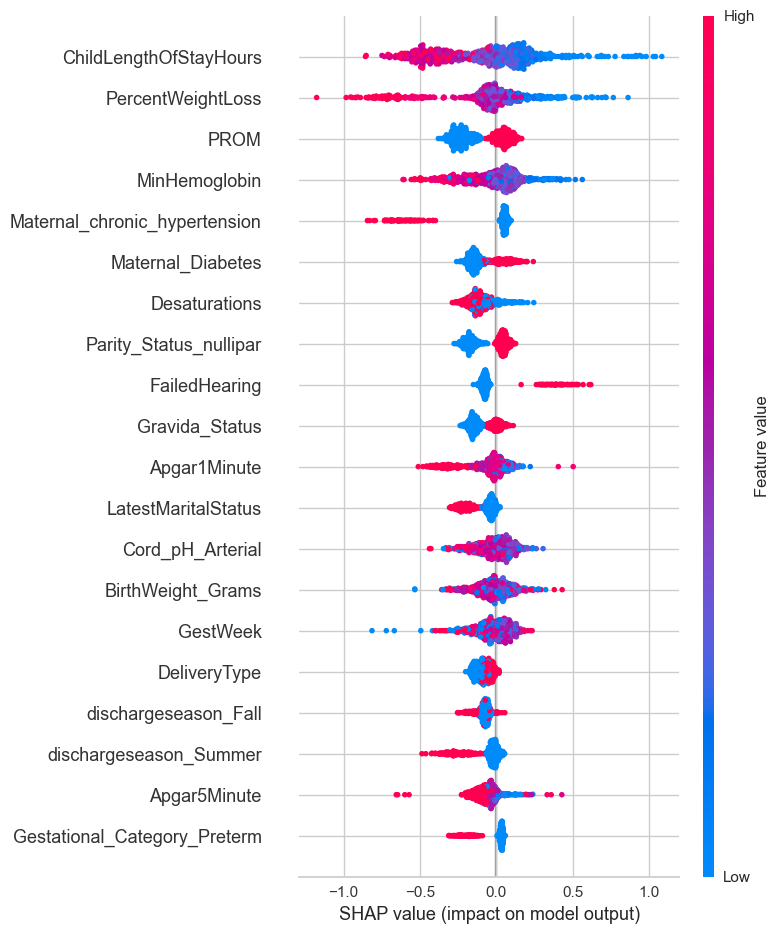

In [58]:
interpret_model(cb)

In [41]:
import ppscore as pps
import seaborn as sns

predictors_df = pps.predictors(data, "target")


ModuleNotFoundError: No module named 'ppscore'

In [ ]:
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,ChildEncounterID,target,0,regression,True,mean absolute error,0.289501,0.401150,DecisionTreeRegressor()
1,MaternalRace,target,0,regression,True,mean absolute error,0.289501,0.411237,DecisionTreeRegressor()
2,LatestMaritalStatus,target,0,regression,True,mean absolute error,0.289501,0.410860,DecisionTreeRegressor()
3,Gravida,target,0,regression,True,mean absolute error,0.289713,0.409662,DecisionTreeRegressor()
4,Parity,target,0,regression,True,mean absolute error,0.289501,0.408311,DecisionTreeRegressor()
5,MultipleGestation,target,0,regression,True,mean absolute error,0.289501,0.410105,DecisionTreeRegressor()
6,Maternal_chronic_hypertension,target,0,regression,True,mean absolute error,0.289501,0.410323,DecisionTreeRegressor()
7,Maternal_Diabetes,target,0,regression,True,mean absolute error,0.289501,0.410569,DecisionTreeRegressor()
8,Maternal_pregnancy_induced_hypertension,target,0,regression,True,mean absolute error,0.289501,0.411733,DecisionTreeRegressor()
9,Oligohydramnios,target,0,regression,True,mean absolute error,0.289501,0.411171,DecisionTreeRegressor()


In [42]:

matrix_df = predictors_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

NameError: name 'predictors_df' is not defined

In [50]:
# Calculate the percentage of missing values for each feature
missing_percentage = data.isnull().mean() * 100

# Filter features with more than 10% missing values
features_with_missing = missing_percentage[missing_percentage > 10]

# Print the features and their missing percentages
print(features_with_missing)

Cord_pH_Arterial    21.171957
MinHemoglobin       12.870596
dtype: float64


In [51]:
# Second Dataset (NICU Data)
# Outcome Definition:
# If the baby is readmitted to the NICU, or
# Has more than 2 PCP (primary care provider) visits, or
# Presents to the ED,
# we will classify this as a “readmission” outcome. (in the first month after discharge )
# First Dataset (NewBorn Nursery Data)
# Exclusive Breastfeeding:
# I will use the “FeedingType” field to distinguish babies receiving Human Milk exclusively from those with other feeding methods. (Some infants may get both human and Donor breastmilk. We should use the definition as "Any Mother's own milk" in the feeding type. If there is a question, we can ask Alex.
# I’ll analyze how exclusive breastfeeding compares to other feeding types in terms of outcomes. I think the outcome should be "Human milk" vs "others". Please let me know what outcome variables are available.
# Cord pH:
# I’ll categorize babies based on whether their cord pH is ≤7 (or another reasonable threshold) and examine any differences in outcomes or feeding status among these groups. Because there are so few subjects (35), I think we can keep a hold on it and concentrate on the other two.
# Timeline
# I plan to complete these analyses within the next two weeks and aim to gather findings that could form the basis of an abstract. Okay. I will be out of the country starting today but can respond to emails. The responses could be delayed.

In [52]:
# Here are my other questions regarding the data:

# Repetitive Patients:
# From what I understand, ChildMedicalRecordNumber is a unique identifier for each patient, and the dataset assumes no duplicate records for the same patient. However, when examining the ChildEncounterID, I noticed that some IDs appear 170-180 times. Could you clarify this? Not sure. We may consider removing those charts. Are the names/date of births also same?

# Race and Ethnicity:
# Would it be problematic to classify race as Caucasian, Black, and Other for the AI model? I plan to explain these demographic details separately for reporting purposes. Not a problem. Is there a possibility of having hispanic? How many hispanics are there?
# LatestMaritalStatus:
# I am considering grouping this feature into Married, Unmarried, and Other. Does this approach align with your preference? What does "Other" mean. If it includes "unknown", that would be "Married" and "Unmarried" and the rest as missing values.
# YearsOfEducation:
# I have converted string values into numerical form, but there is a significant amount of missing data for this feature. I am still evaluating whether to include it in the ML model. Yes, there are missing variables. If data availability is less than 10%, I think we can remove the variable.
# Gravida and Parity Features:
# For the missing values in these features, would it be reasonable to assume a value of 0 for the ML model? No. It should still be missing.
# Delivery Type:
# I plan to categorize this feature into Vaginal and C-Section. However, there seems to be a discrepancy between the DeliveryType feature, where the count for vaginal delivery is 22,817, and the VaginalDelivery feature, which shows a count of 17,295. Could you clarify this inconsistency? Not sure. we can discuss and you can show me.
# AppointmentMadeDuringAdmission:
# Could you explain the meaning of this feature? Does it indicate appointments scheduled prior to discharge? Yes. 
# Cord Blood Gas:
# I noticed that cord blood gas data is available for only one-third of the patients. I understand that routine cord blood gas measurement may not be part of your practice. Could you clarify the criteria for ordering these tests? In our practice, we typically order them in cases of prolonged labor, suspected HIE, or when NRP is anticipated or performed. The criteria varies between different hospitals in the same system. Not consistent. One hospital does for almost all babies and the other does for very few. Cant help that! 🙂 
# Hearing Tests:
# In our practice, hearing tests are usually performed on the second or third day or during the first postnatal examination. Are hearing tests in your practice conducted immediately before discharge? In our practice, before discharge
# PercentWeightLoss:
# Does this feature represent data from the 24th hour or just prior to discharge? Prior to discharge.

In [2]:
# High risk data
'MaternalPatientID', 'MaternalMedicalRecordNumber', 
'ChildPatientID','ChildMedicalRecordNumber', 

#'ChildEncounterID', 
# Clinic Data
# Maternal Demographic Characteristics
'MaternalAgeAtDelivery', # >30 age risky mother
'MaternalRace', 
#'MaternalLanguage', 
#'MyChartAccess', # pval 0.93 chi2 0.0007
'LatestMaritalStatus', 
'YearsOfEducation', # Only 5% data we can just mentioned this statistical results
# MWU for yearsofeducation p 0.66 thats meant doesnt significant for readmission
'Gravida', # Significant
'Parity', # Significant
'DeliveryDate', # For season or month 
'GestationalAge_Weeks', #
'GestAge_Days', # More continious continious data better than splitted data
'ChildDeathDate', # 25 dead baby but only 2 baby admitted or only 6 admitted
# Also 18 baby dead at first hour they could be excluded
'MaternalDeathDate', 
# Children demographic characteristics
'ChildGender', # p 0.43 didnt significant
'ChildRace', # Unnecessary
'ChildEthnicity', # Unnecessary

# Prenatal Characteristics
'Mother_BMI_AtDelivery', 
'PrePregnancyWeight_KG',
'PositiveDrugScreenDuringPregnancy', #p 0.001 doesnt significant
'Alcohol abuse', # p val 0.93
'Smoking during pregnancy', # 0.013
# Enfections
'HepB_PositiveDuringPregnancy', # p val 0.42
'HCV_PositiveDuringPregnancy', #0.31
'HIV_PositiveDuringPregnancy', # 0.83
'SyphilisPositiveDuringPregnancy', # 0.55
'GBS_PositiveDuringPregnancy', # 0.016
'AnyInfection' #0.118
# Prenatal Complications and Other Situations
'Antepartum Haemorrhage', #0.001
'Eclampsia', #0.54
'IUGR', # 0.02
'Maternal chronic hypertension', #0.51
'Maternal Diabetes', # 0.84
'Maternal pregnancy-induced hypertension', # 0.022
'Oligohydramnios', #0.191
'Placenta previa', # 0.59
'Polyhydramnios', # 0.78
'Pre-eclampsia', #0.70
'Pregnancy Complications', # 0.09
'Preterm premature rupture of membranes', #0.01
'Spontaneous abortion', #0.62
'Umbilical cord prolapse', #0.26


'Vaginal delivery', # 0.12
# Drop This Features because doesnt have data NA all of there
# SSRI_DuringPregnancy,Suboxone_DuringPregnancy
#  
# Natal and Delivery Characteristics
'DeliveryType', 
'ROM_Time', # When I looking biger than 24*60 minutes I found 25515 line. This feature doesnt meaningful
'MultipleGestation', # 0.234

# ER visit Characteristics
'ER_VisitDuringPregnancy', # 0.0001
'ChildER_VisitFirstMonth', #
'ChildReadmissionFirstMonth', 
'ChildOfficeVisitsFirstMonth', #0.0001 bu this is after the discharge feature

'AppointmentMadeDuringAdmission', #0.72
# Ward characteristics
'ChildLengthOfStayHours', # 0.006
'DischargeMonth', # 0.176
'BirthWeight_Grams', # 0.000001
'SGA', 
# Postnatal Characteristics       
'Apgar1Minute', # 0.001
'Apgar5Minute', # 0.82
'Cord_pH_Venous_Date', 
'Cord_pH_Venous', 
'Cord_pH_Arterial_Date',
'Cord_pH_Arterial', # 0.56
'MaxHeartRate', #0.02
'MinHeartRate', #0.2
'AvgHeartRate', #0.4
'AvgPulseOx', #0.008
'Desaturations', #0.159
'MaxTemperature', # 0.38
'MinTemperature', # 0.003
'MinBloodGlucose', # 0.70
'MaxBloodGlucose', # 0.12
'MinSerumBilirubin', # 0.72
'MaxSerumBilirubin', #0.26
'MaxTranscutaneousBilirubin',
'MinTranscutaneousBilirubin', #<0.0001
'Phototherapy', #0.92
'FailedHearing', #0.012
'CarSeatTestFailures', #0.30
'FeedingType', #<0.0001
'PercentWeightLoss' #<0.0001

,MaternalPatientID,MaternalMedicalRecordNumber,ChildPatientID,ChildMedicalRecordNumber,ChildEncounterID,MaternalAgeAtDelivery,MaternalRace,MaternalLanguage,MyChartAccess,LatestMaritalStatus,...,MaxSodium,MinHemoglobin,NoUrineOutputShift,FailedHearing,CarSeatTestFailures,FeedingType,PercentWeightLoss,ChildNumberOfAntibioticDays,ChildBloodCultureCount,HighestIVH_Grade
0,1305371312,45688038,44010055666,87656644,440501698459,34,Caucasian,English Language,Y,Currently Married,...,131.0,6.2,NaN,N,0.0,Human Milk,-4.0,1,1,NaN
1,1505532815,48870872,44010068969,87669963,440504054744,40,Caucasian,English Language,Y,Currently Married,...,NaN,NaN,NaN,N,NaN,NaN,-6.7,1,0,NaN
2,4407414710,78492406,44010436597,88007435,440522143899,34,Black race,English Language,Y,Currently Married,...,140.0,15.7,NaN,N,0.0,NaN,-2.9,1,1,NaN
3,1404830468,50478459,44010496774,88064170,440534232207,30,Black race,English Language,Y,Unmarried person,...,135.0,15.0,NaN,N,0.0,NaN,8.0,2,1,NaN
4,1406563734,79711888,44010497458,88064856,440534411559,27,Caucasian,English Language,Y,Unmarried person,...,145.0,10.5,NaN,N,0.0,NaN,150.8,8,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,4408307041,80778864,4408487557,82710434,440325858050,33,Caucasian,English Language,Y,Currently Married,...,NaN,NaN,NaN,NaN,NaN,Human Milk,-0.8,1,0,NaN
4129,140Z1242664,23856220,4408523464,83101016,440329974003,31,Caucasian,English Language,Y,Currently Married,...,132.0,23.9,NaN,N,NaN,Human Milk,-2.2,1,0,NaN
4130,1505638122,55835896,4408541980,83296127,440332062274,27,Race: [other] or [not stated],English Language,Y,Currently Married,...,142.0,15.0,NaN,N,0.0,NaN,100.3,3,1,NaN
4131,1305583234,53333273,4408553628,83416530,440333332621,28,Caucasian,English Language,Y,Currently Married,...,NaN,14.4,NaN,N,NaN,Human Milk,-2.9,4,0,NaN
